In [1]:
import torch
from math import pi,sqrt,log,e,exp
from time import time
from matplotlib import pyplot
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
#torch.set_default_dtype(torch.float64)
device = torch.device("cuda:6")

In [2]:
from src.models.flows.coupling_cells.real_nvp import RealNVP
from src.models.flows.sampling import FactorizedGaussianSampler, UniformSampler
from src.models.flows.analytic_flows.element_wise import InvertibleAnalyticSigmoid
from src.models.flows.sequential import InvertibleSequentialFlow
from src.training.weighted_dataset.dkl_training import BasicStatefulDKLTrainer
from src import setup_std_stream_logger
from src.integration.flat_survey_integrator import FlatSurveySamplingIntegrator

In [3]:
setup_std_stream_logger(debug=True)

In [4]:
def f(x):
    return torch.exp( - torch.sum(((x-0.25)/0.1)**2,axis=-1))+torch.exp( - torch.sum(((x-0.75)/0.1)**2,axis=-1))

In [5]:
posterior=UniformSampler(d=2,low=0.,high=1.,device=device)
prior=FactorizedGaussianSampler(d=2,device=device)

In [12]:
try:
    del model
except:
    pass


model  = InvertibleSequentialFlow(2,[
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=256,
              n_hidden=16,).to(device),
    InvertibleAnalyticSigmoid(d=2),
])

optim = torch.optim.Adam(model.parameters(),lr=1.e-3)

In [13]:
trainer = BasicStatefulDKLTrainer(flow=model,latent_prior=prior)

In [14]:
trainer.set_config(n_epochs=10, minibatch_size=20000, optim=optim)

In [15]:
integrator=FlatSurveySamplingIntegrator(f,trainer,2,device=device)

In [16]:
result=integrator.integrate(10,10,verbosity=3, trainer_verbosity=3)

Starting integration
Initializing the survey phase
Starting the survey phase
Integral: 6.224e-02 +/- 5.218e-04
Integral: 6.336e-02 +/- 5.271e-04
Integral: 6.323e-02 +/- 5.257e-04
Integral: 6.250e-02 +/- 5.223e-04
Integral: 6.240e-02 +/- 5.199e-04
Integral: 6.214e-02 +/- 5.214e-04
Integral: 6.291e-02 +/- 5.254e-04
Integral: 6.331e-02 +/- 5.263e-04
Integral: 6.284e-02 +/- 5.222e-04
Integral: 6.259e-02 +/- 5.234e-04
Finalizing the survey phase
Initializing the refine phase
Starting the refine phase
Integral: 6.254e-02 +/- 2.063e-04
Integral: 6.242e-02 +/- 1.792e-04
Integral: 6.241e-02 +/- 1.978e-04
Integral: 6.230e-02 +/- 1.711e-04
Integral: 6.220e-02 +/- 1.470e-04
Integral: 6.364e-02 +/- 7.601e-04
Integral: 6.236e-02 +/- 1.720e-04
Integral: 6.248e-02 +/- 1.787e-04
Integral: 6.257e-02 +/- 3.084e-04
Integral: 6.262e-02 +/- 2.355e-04
Finalizing the refine phase
Final result: 6.25534e-02 +/- 9.76960e-05


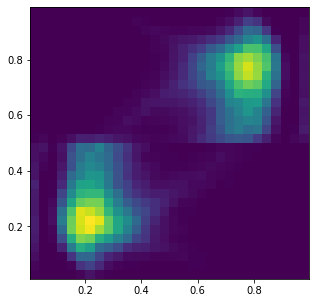

In [17]:
x=trainer.sample_forward(100000).cpu().numpy()
plt.figure(figsize=(5,5))
plt.hist2d(x[:,0],x[:,1],bins=30)
plt.show()

In [68]:
OneDimGaussian = 0.0354491

In [125]:
def build_checker_integrator(d,reps=2,lr=1.e-4,f=f,epochs=10):
    layers = []
    for rep in range(reps):
        for i in range(2):
            mask = [j % 2 == i for j in range(d)]
            layers.append(
                RealNVP(d=d,
                  mask=mask,
                  d_hidden=256,
                  n_hidden=16,).to(device),
            )
    layers.append(InvertibleAnalyticSigmoid(d=2))
    
    model = InvertibleSequentialFlow(d,layers)
    optim = torch.optim.Adam(model.parameters(),lr=lr)
    prior=FactorizedGaussianSampler(d=d,device=device)
    
    trainer = BasicStatefulDKLTrainer(flow=model,latent_prior=prior)
    trainer.set_config(n_epochs=epochs, minibatch_size=20000, optim=torch.optim.Adam(model.parameters()))
    integrator=FlatSurveySamplingIntegrator(f,trainer,d,device=device)
    
    return integrator

In [128]:
results = pd.DataFrame({
    "d":pd.Series([],dtype="int"),
    "integral": pd.Series([],dtype="float"),
    "error": pd.Series([],dtype="float"),
    "nsig":pd.Series([],dtype="float"),
    "speedup": pd.Series([],dtype="float"),
})

In [129]:
d=2
integrator = build_checker_integrator(d=d,lr=1.e-5)
result = integrator.integrate(5,10)
speedup = (result[2].loc[result[2]["phase"] == "survey"]["error"].mean()/result[2].loc[result[2]["phase"] == "refine"]["error"].mean())**2
results = results.append({"integral": result[0], "error": result[1], "nsig":abs(result[0] - OneDimGaussian**d)/result[1],"speedup": speedup, "d":d},ignore_index=True)
integrator = build_checker_integrator(d=d,lr=1.e-5)
result = integrator.integrate(5,10)
speedup = (result[2].loc[result[2]["phase"] == "survey"]["error"].mean()/result[2].loc[result[2]["phase"] == "refine"]["error"].mean())**2
results = results.append({"integral": result[0], "error": result[1], "nsig":abs(result[0] - OneDimGaussian**d)/result[1],"speedup": speedup, "d":d},ignore_index=True)

Starting integration
Initializing the survey phase
Starting the survey phase
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 1.231e-03 +/- 7.725e-05
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 1.337e-03 +/- 8.175e-05
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 1.258e-03 +/- 7.811e-05
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 1.269e-03 +/- 7.740e-05
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 1.276e-03 +/- 8.111e-05
Finalizing the survey phase
Initi

In [130]:
d=3
integrator = build_checker_integrator(d=d,lr=1.e-5)
result = integrator.integrate(5,10)
speedup = (result[2].loc[result[2]["phase"] == "survey"]["error"].mean()/result[2].loc[result[2]["phase"] == "refine"]["error"].mean())**2
results = results.append({"integral": result[0], "error": result[1], "nsig":abs(result[0] - OneDimGaussian**d)/result[1],"speedup": speedup, "d":d},ignore_index=True)
integrator = build_checker_integrator(d=d,lr=1.e-5)
result = integrator.integrate(5,10)
speedup = (result[2].loc[result[2]["phase"] == "survey"]["error"].mean()/result[2].loc[result[2]["phase"] == "refine"]["error"].mean())**2
results = results.append({"integral": result[0], "error": result[1], "nsig":abs(result[0] - OneDimGaussian**d)/result[1],"speedup": speedup, "d":d},ignore_index=True)

Starting integration
Initializing the survey phase
Starting the survey phase
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 3.386e-05 +/- 8.529e-06
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 3.735e-05 +/- 9.366e-06
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 3.569e-05 +/- 9.787e-06
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 4.376e-05 +/- 1.267e-05
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 3.411e-05 +/- 9.071e-06
Finalizing the survey phase
Initi

In [131]:
d=4
integrator = build_checker_integrator(d=d,lr=1.e-5)
result = integrator.integrate(5,10)
speedup = (result[2].loc[result[2]["phase"] == "survey"]["error"].mean()/result[2].loc[result[2]["phase"] == "refine"]["error"].mean())**2
results = results.append({"integral": result[0], "error": result[1], "nsig":abs(result[0] - OneDimGaussian**d)/result[1],"speedup": speedup, "d":d},ignore_index=True)
integrator = build_checker_integrator(d=d,lr=1.e-5)
result = integrator.integrate(5,10)
speedup = (result[2].loc[result[2]["phase"] == "survey"]["error"].mean()/result[2].loc[result[2]["phase"] == "refine"]["error"].mean())**2
results = results.append({"integral": result[0], "error": result[1], "nsig":abs(result[0] - OneDimGaussian**d)/result[1],"speedup": speedup, "d":d},ignore_index=True)

Starting integration
Initializing the survey phase
Starting the survey phase
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 4.150e-07 +/- 2.957e-07
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 7.503e-07 +/- 4.941e-07
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 7.269e-06 +/- 3.582e-06
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 7.917e-06 +/- 7.648e-06
Training on batch: 100000 points
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Integral: 1.661e-06 +/- 1.401e-06
Finalizing the survey phase
Initi

In [132]:
results

,d,integral,error,nsig,speedup
0,2.0,0.001257,1.219308e-07,0.878537,42110.643727
1,2.0,0.001257,1.191610e-07,0.389279,44260.413937
2,3.0,0.000045,2.050837e-08,0.015207,23230.212388
3,3.0,0.000045,2.188458e-08,0.209834,39122.460256
4,4.0,0.000001,6.346373e-08,8.964754,228.527436
5,4.0,0.000002,2.135036e-09,0.754387,10211.385995
